workqueue |  1 thr | 0.017 ± 0.002 s   (layer used: workqueue)
workqueue |  2 thr | 0.010 ± 0.002 s   (layer used: workqueue)
workqueue |  4 thr | 0.007 ± 0.000 s   (layer used: workqueue)
workqueue |  8 thr | 0.005 ± 0.001 s   (layer used: workqueue)
workqueue | 12 thr | 0.004 ± 0.000 s   (layer used: workqueue)
workqueue | 16 thr | 0.004 ± 0.000 s   (layer used: workqueue)
workqueue | 20 thr | 0.004 ± 0.000 s   (layer used: workqueue)
────────────────────────────────────────────────────────────
omp       |  1 thr | 0.016 ± 0.001 s   (layer used: omp)
omp       |  2 thr | 0.010 ± 0.001 s   (layer used: omp)
omp       |  4 thr | 0.008 ± 0.001 s   (layer used: omp)
omp       |  8 thr | 0.005 ± 0.001 s   (layer used: omp)
omp       | 12 thr | 0.005 ± 0.001 s   (layer used: omp)
omp       | 16 thr | 0.006 ± 0.002 s   (layer used: omp)
omp       | 20 thr | 0.006 ± 0.001 s   (layer used: omp)
────────────────────────────────────────────────────────────


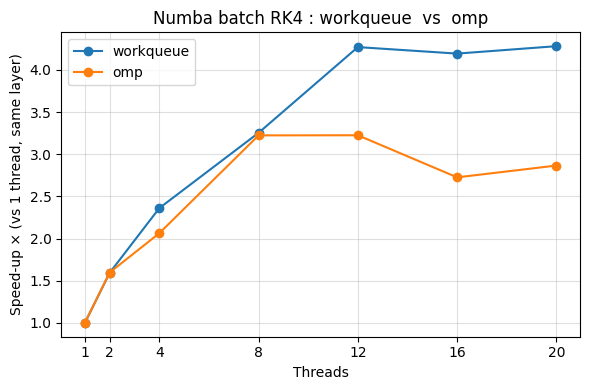

In [3]:
# ╔════════════════════════════════════════════════════════════╗
# ║   NUMBA threading-layer benchmark: workqueue  vs  omp      ║
# ╚════════════════════════════════════════════════════════════╝
import os, sys, time, statistics as st, numpy as np, matplotlib.pyplot as plt

# ── вспомогательная функция: полностью выгрузить numba ─────────
def unload_numba():
    for m in [k for k in list(sys.modules) if k.startswith("numba")]:
        del sys.modules[m]

# ── бенчмарк для заданного слоя и числа потоков ────────────────
def bench_layer(layer: str, n_threads: int, N=1_000_000, repeats=5):
    unload_numba()                                  # «чистый» импорт
    os.environ["NUMBA_THREADING_LAYER"] = layer
    import numba
    from numba import njit, prange

    # — параметры маятника —
    g, l, m, c, u = 9.81, 2.0, 1.0, 0.1, 0.0
    inv_ml2, dt = 1.0 / (m * l * l), 0.01

    @njit(parallel=True, fastmath=True)
    def batch_rk4(states, controls, dts):
        out = np.empty_like(states)
        for i in prange(states.shape[0]):
            th, om = states[i]
            ui, dti = controls[i], dts[i]
            # RK4
            k1t, k1o = om, -g/l*np.sin(th) - c*om + ui*inv_ml2
            k2t, k2o = om+0.5*dti*k1o, -g/l*np.sin(th+0.5*dti*k1t)-c*(om+0.5*dti*k1o)+ui*inv_ml2
            k3t, k3o = om+0.5*dti*k2o, -g/l*np.sin(th+0.5*dti*k2t)-c*(om+0.5*dti*k2o)+ui*inv_ml2
            k4t, k4o = om+dti*k3o,     -g/l*np.sin(th+dti*k3t)    -c*(om+dti*k3o)    +ui*inv_ml2
            out[i,0] = th + (dti/6)*(k1t+2*k2t+2*k3t+k4t)
            out[i,1] = om + (dti/6)*(k1o+2*k2o+2*k3o+k4o)
        return out

    numba.set_num_threads(n_threads)

    # данные
    states   = np.zeros((N, 2))
    controls = np.zeros(N) + u
    dts      = np.zeros(N) + dt

    # прогрев компиляции
    batch_rk4(states[:10], controls[:10], dts[:10])

    # измеряем
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        batch_rk4(states, controls, dts)
        times.append(time.perf_counter() - t0)

    return st.mean(times), st.stdev(times), numba.threading_layer()

# ── набор потоков для пробы ───────────────────────────────────
max_thr = os.cpu_count()
thread_list = [1, 2, 4, 8, 12, 16, min(20, max_thr)]

layers = ["workqueue", "omp"]
results = {}

for layer in layers:
    layer_res = {}
    for t in thread_list:
        mean_t, std_t, active = bench_layer(layer, t)
        layer_res[t] = (mean_t, std_t)
        print(f"{layer:<9s} | {t:2d} thr | {mean_t:.3f} ± {std_t:.3f} s   (layer used: {active})")
    results[layer] = layer_res
    print("─"*60)

# ── строим график ускорения ───────────────────────────────────
plt.figure(figsize=(6,4))
for layer, res in results.items():
    base = res[1][0]               # время при 1 потоке того же слоя
    speed = [base / res[t][0] for t in thread_list]
    plt.plot(thread_list, speed, 'o-', label=layer)

plt.xlabel("Threads")
plt.ylabel("Speed-up × (vs 1 thread, same layer)")
plt.title("Numba batch RK4 : workqueue  vs  omp")
plt.grid(alpha=0.4)
plt.xticks(thread_list)
plt.legend()
plt.tight_layout()
plt.show()
